### Notebook for the CCCI-derived metabolism from scRNA-Seq using `mebocost` - COPD-CTRL

- **Developed by**: Carlos Talavera-López Ph.D
- **Institute of Computational Biology - Computational Health Centre - Hemlholtz Munich**
- v230324

### Import required modules

In [1]:
import os,sys
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from mebocost import mebocost

Warning (xlmhg): Failed to import "mhg_cython" C extension.
Warning (xlmhg): Failed to import the "mhg_cython" C extension.Falling back to the pure Python implementation, which is very slow.


In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.8.0
scanpy      1.8.2
sinfo       0.3.4
-----
Cython              0.29.33
PIL                 9.4.0
adjustText          NA
appnope             0.1.3
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cffi                1.15.1
comm                0.1.3
cpuinfo             NA
cycler              0.10.0
cython              0.29.33
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.6
decorator           5.1.1
defusedxml         

### Read in dataset

In [3]:
BrEpit_ALL = sc.read_h5ad('../data/Marburg_All_ctl230404_leiden_states.raw.h5ad') 
BrEpit_ALL

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'group', 'C_scANVI', 'cell_type', 'leiden', 'leiden_states'
    var: 'mt', 'ribo', 'n_cells_by_counts-V1', 'mean_counts-V1', 'pct_dropout_by_counts-V1', 'total_counts-V1', 'n_cells_by_counts-V2', 'mean_counts-V2', 'pct_dropout_by_counts-V2', 'total_counts-V2', 'n_cells_by_counts-V3', 'mean_counts-V3', 'pct_dropout_by_counts-V3', 'total_counts-V3', 'n_cells_by_counts-V4', 'mean_counts-V4', 'pct_dropout_by_counts-V4', 'total_counts-V4', 'n_cells_by_counts-V5', 'mean_counts-V5', 'pct_dropout_by_coun

In [4]:
BrEpit_ALL.obs['group'].value_counts()

copd_ctrl       26261
copd_iav        24958
healthy_ctrl    23667
healthy_iav     22687
Name: group, dtype: int64

In [5]:
adata = BrEpit_ALL[BrEpit_ALL.obs['group'].isin(['copd_ctrl'])]
adata

View of AnnData object with n_obs × n_vars = 26261 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'group', 'C_scANVI', 'cell_type', 'leiden', 'leiden_states'
    var: 'mt', 'ribo', 'n_cells_by_counts-V1', 'mean_counts-V1', 'pct_dropout_by_counts-V1', 'total_counts-V1', 'n_cells_by_counts-V2', 'mean_counts-V2', 'pct_dropout_by_counts-V2', 'total_counts-V2', 'n_cells_by_counts-V3', 'mean_counts-V3', 'pct_dropout_by_counts-V3', 'total_counts-V3', 'n_cells_by_counts-V4', 'mean_counts-V4', 'pct_dropout_by_counts-V4', 'total_counts-V4', 'n_cells_by_counts-V5', 'mean_counts-V5', 'pct_dropout

### Infer Highly Variable Genes to speed up and improve inference

In [6]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "donor",
    subset = True
)

adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 26261 × 7000
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'group', 'C_scANVI', 'cell_type', 'leiden', 'leiden_states'
    var: 'mt', 'ribo', 'n_cells_by_counts-V1', 'mean_counts-V1', 'pct_dropout_by_counts-V1', 'total_counts-V1', 'n_cells_by_counts-V2', 'mean_counts-V2', 'pct_dropout_by_counts-V2', 'total_counts-V2', 'n_cells_by_counts-V3', 'mean_counts-V3', 'pct_dropout_by_counts-V3', 'total_counts-V3', 'n_cells_by_counts-V4', 'mean_counts-V4', 'pct_dropout_by_counts-V4', 'total_counts-V4', 'n_cells_by_counts-V5', 'mean_counts-V5', 'pct_dropout_by_count

### Infer metabolic communications

- The `mebocost.conf` file needs to be provided. It is in the original repo and after installation it will have the correct paths and should work out of the box. You could provide the full path to the file, or create a symlink. 

In [7]:
mebo_obj = mebocost.create_obj(
                        adata = adata,
                        group_col = ['leiden_states'],
                        met_est = 'mebocost',
                        config_path = './mebocost.conf',
                        exp_mat = None,
                        cell_ann = None,
                        species = 'human',
                        met_pred = None,
                        met_enzyme = None,
                        met_sensor = None,
                        met_ann = None,
                        scFEA_ann = None,
                        compass_met_ann = None,
                        compass_rxn_ann = None,
                        gene_network = None,
                        gmt_path = None,
                        cutoff_exp = 'auto', ## automated cutoff to exclude lowly ranked 25% sensors across all cells
                        cutoff_met = 'auto', ## automated cutoff to exclude lowly ranked 25% metabolites across all cells
                        cutoff_prop = 0.25, ## at lease 25% of cells should be expressed the sensor or present the metabolite in the cell group (specified by group_col)
                        sensor_type = ['Receptor', 'Transporter', 'Nuclear Receptor'],
                        thread = 4
                        )

[April 27, 2023 10:57:03]: We get expression data with 7000 genes and 26261 cells.
[April 27, 2023 10:57:03]: Data Preparation Done in 0.1485 seconds


### Estimate metabolite presence

- If you just want the table of metabolic activity, you can stop here and export it as a CSV file. 

In [8]:
mebo_obj._load_config_()
mebo_obj.estimator()

[April 27, 2023 10:57:03]: Load config and read data based on given species [human].
[April 27, 2023 10:57:05]: Estimtate metabolite level using mebocost


In [9]:
met_mat = pd.DataFrame(mebo_obj.met_mat.toarray(),
                      index = mebo_obj.met_mat_indexer,
                      columns = mebo_obj.met_mat_columns)
met_mat.head()

,711539-ST09_CSE_IAV-V1,712557-ST09_CSE_IAV-V1,548541-ST09_CSE_IAV-V1,235387-ST09_CSE_IAV-V1,843167-ST09_CSE_IAV-V1,429761-ST09_CSE_IAV-V1,180538-ST09_CSE_IAV-V1,877284-ST09_CSE_IAV-V1,719369-ST09_CSE_IAV-V1,808473-ST09_CSE_IAV-V1,...,7998788-CSE03_CTRL-V6,1633943-CSE03_CTRL-V6,13157829-CSE03_CTRL-V6,5759657-CSE03_CTRL-V6,2825919-CSE03_CTRL-V6,9600822-CSE03_CTRL-V6,12250460-CSE03_CTRL-V6,3863124-CSE03_CTRL-V6,4148054-CSE03_CTRL-V6,4291292-CSE03_CTRL-V6
HMDB0001188,2.0,1.0,8.0,3.0,8.0,2.0,0.0,1.0,6.0,0.0,...,0.0,0.0,4.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0
HMDB0000699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HMDB0006875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HMDB0000972,2.0,5.0,5.0,0.0,11.0,0.0,4.0,8.0,0.0,7.0,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HMDB0004673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
met_mat.shape

(311, 26261)

### MEBOCOST cell-cell communication inference

In [11]:
commu_res = mebo_obj.infer_commu(
                                n_shuffle = 1000,
                                seed = 1712, 
                                Return = True, 
                                thread = 4,
                                save_permuation = False,
                                min_cell_number = 3
                            )

[April 27, 2023 10:57:29]: Load config and read data based on given species [human].
[April 27, 2023 10:57:31]: Estimtate metabolite level using mebocost
[April 27, 2023 10:57:47]: Infer communications
[April 27, 2023 10:57:47]: Sensor type used ['Transporter', 'Receptor', 'Nuclear Receptor']
[April 27, 2023 10:57:47]: Parameters: {shuffling: 1000 times, random seed: 1712, thread: 4}
[April 27, 2023 10:58:08]: met_sensor: (67, 8)
[April 27, 2023 10:58:08]: avg_exp: (465, 19) for (gene, cell) of needed
[April 27, 2023 10:58:08]: avg_met: (311, 19) for (metabolite, cell) of needed
[April 27, 2023 10:58:08]: shuffling 1000 times for generating backgroud
[April 27, 2023 10:58:24]: take exp and met avg for shuffling
[April 27, 2023 11:01:10]: thread: 4
[April 27, 2023 11:01:18]: ABCA1 ~ HMDB0006247
[April 27, 2023 11:01:18]: Normalizing Cluster Mean and Calculating Communication Score
[April 27, 2023 11:01:18]: Calculating P-value
[April 27, 2023 11:01:21]: SLC38A2 ~ HMDB0000641
[April 27, 

In [12]:
print('sensor_exp cutoff: %s'%mebo_obj.cutoff_exp)
print('metabolite_presence cutoff: %s'%mebo_obj.cutoff_met)

sensor_exp cutoff: 2.0
metabolite_presence cutoff: 1.0


### Visualise MEBOCOST prediction

- Summary of the number of communication events

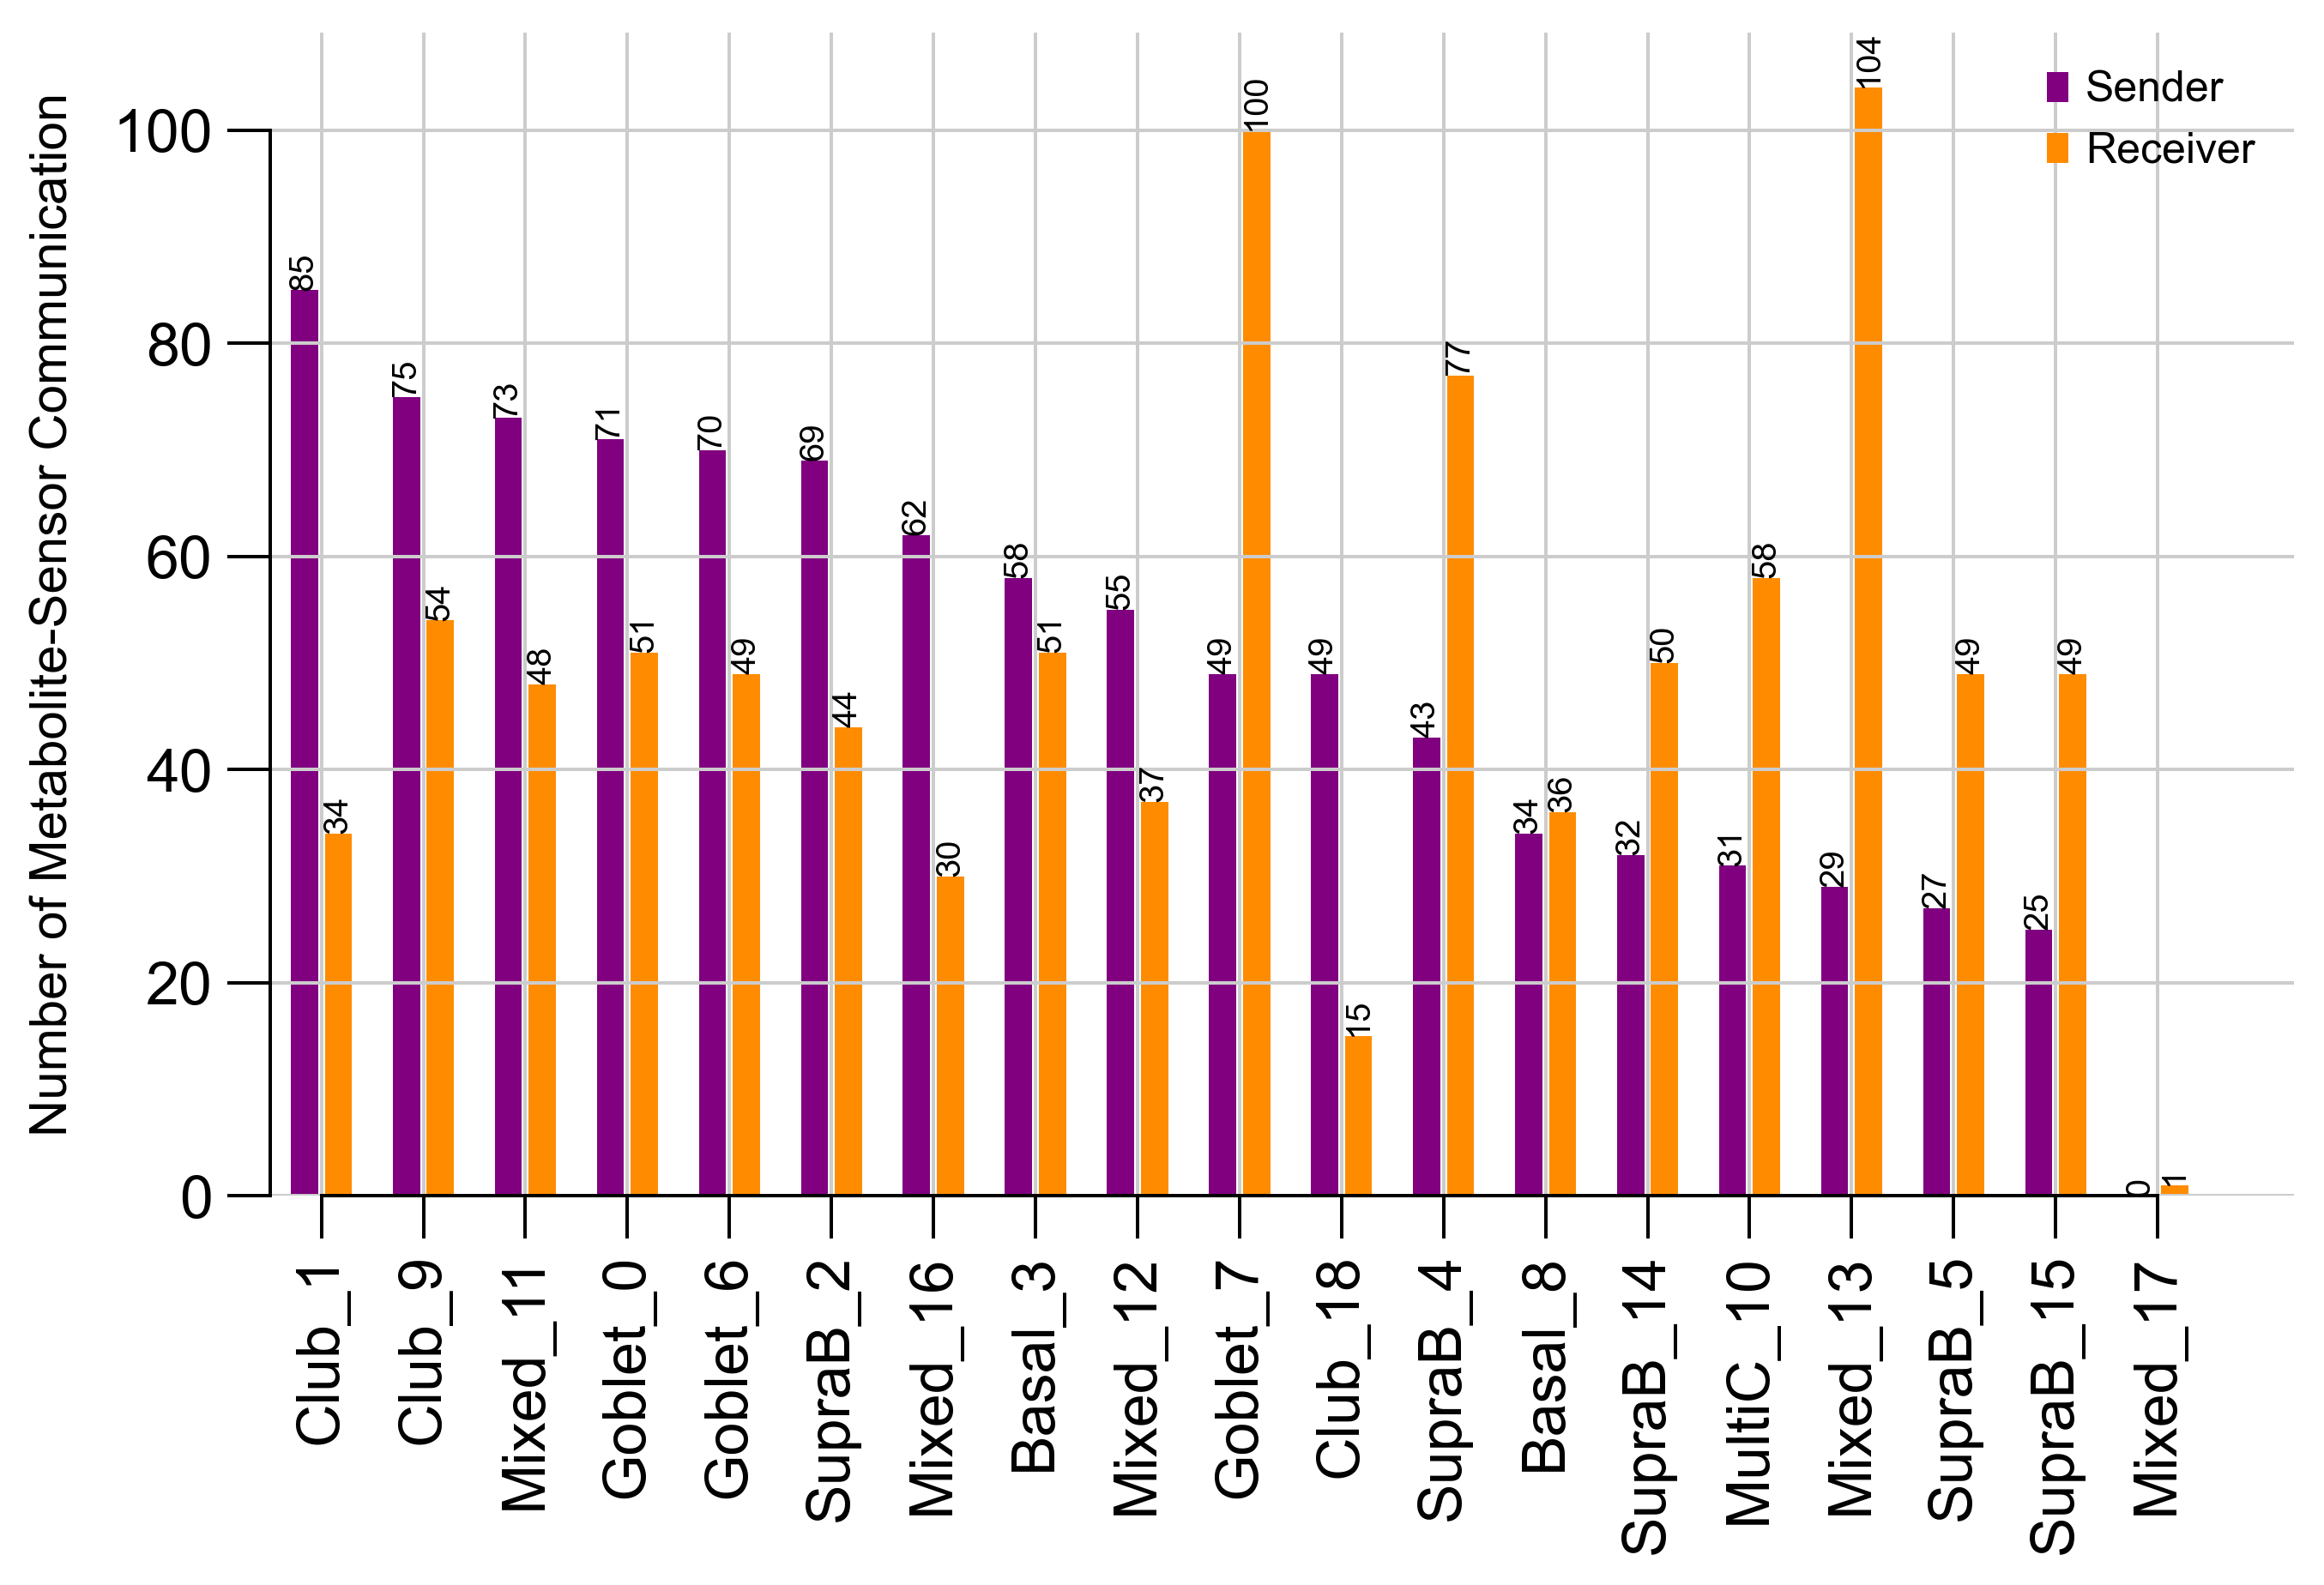

In [13]:
mebo_obj.eventnum_bar(
                    sender_focus = [],
                    metabolite_focus = [],
                    sensor_focus = [],
                    receiver_focus = [],
                    and_or = 'and',
                    pval_method = 'permutation_test_fdr',
                    pval_cutoff = 0.05,
                    comm_score_col = 'Commu_Score',
                    comm_score_cutoff = 0,
                    cutoff_prop = 0.25,
                    figsize = 'auto',
                    save = None,
                    show_plot = True,
                    show_num = True,
                    include = ['sender-receiver'],
                    group_by_cell = True,
                    colorcmap = 'tab20',
                    return_fig = False
                )

- Showing the communication between sender and receiver in a dot plot

[April 27, 2023 11:04:02]: plot dot plot to show communication in cell type level


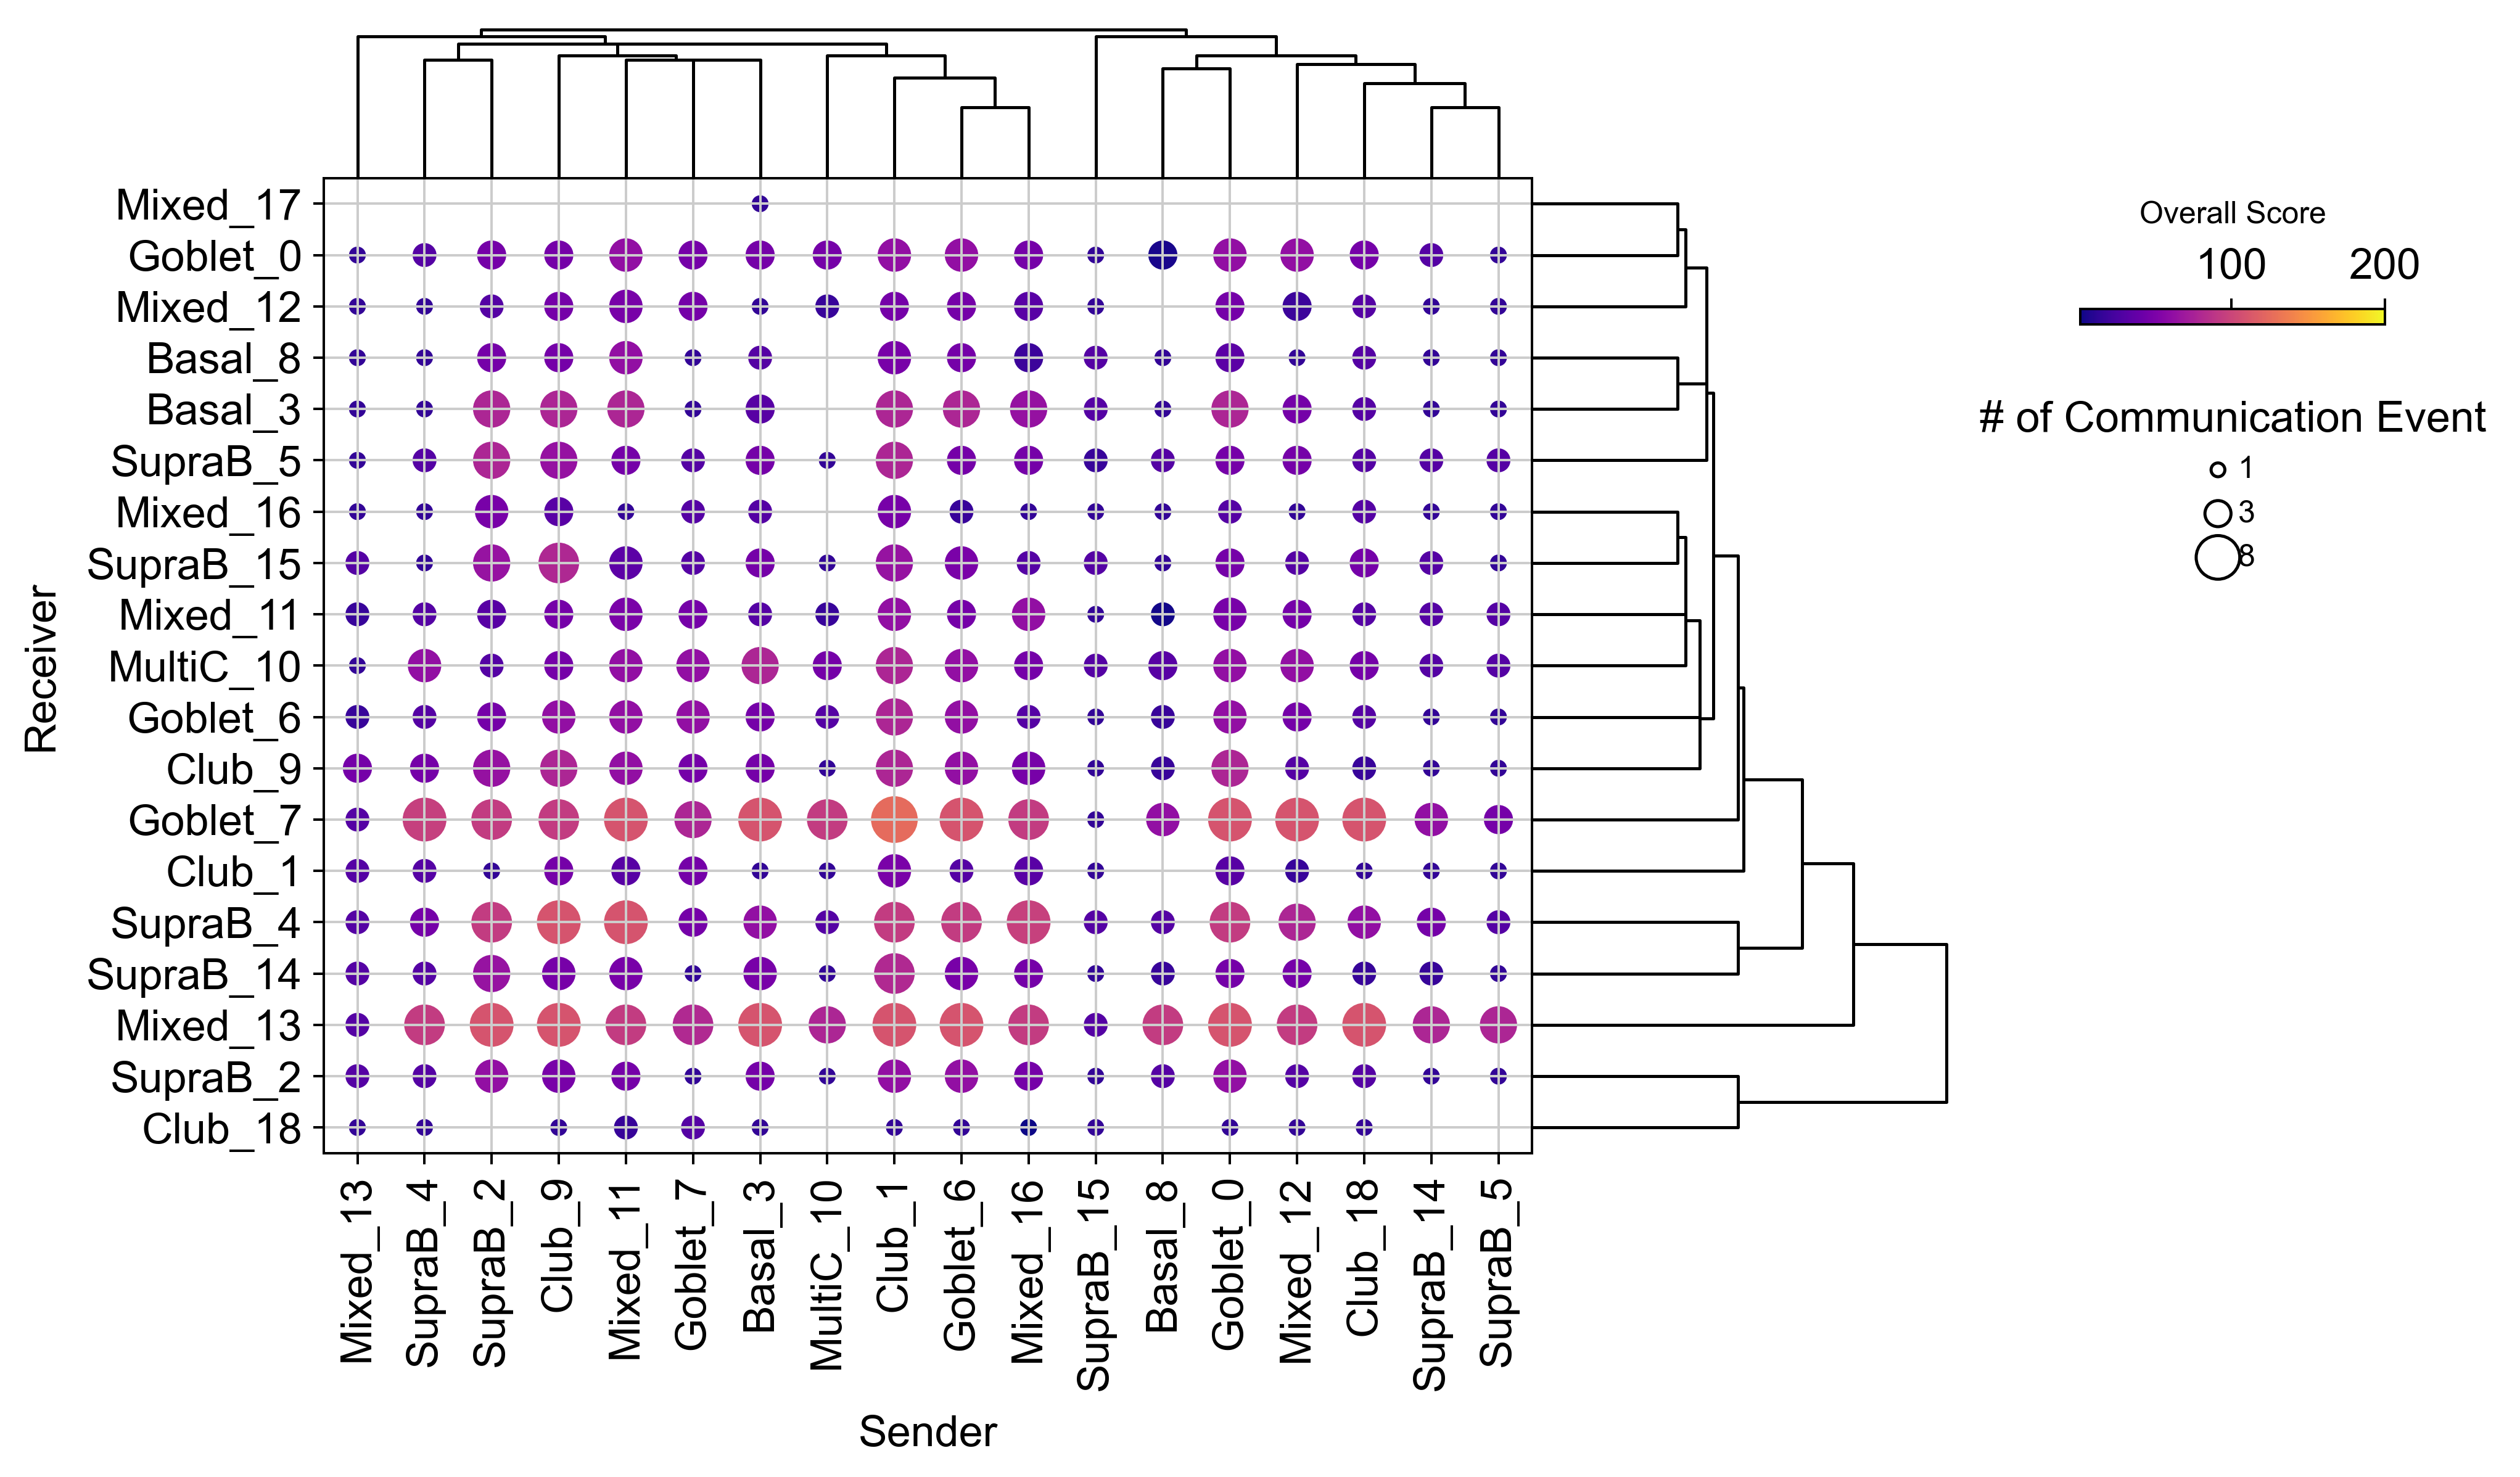

In [14]:
mebo_obj.count_dot_plot(
                        pval_method = 'permutation_test_fdr',
                        pval_cutoff = 0.05,
                        cmap = 'plasma',
                        figsize = 'auto',
                        save = None,
                        dot_size_norm = (20, 200),
                        dot_color_vmin = None,
                        dot_color_vmax = 200,
                        show_plot = True,
                        comm_score_col = 'Commu_Score',
                        comm_score_cutoff = 0,
                        return_fig = False
                    )

- Showing the detailed communications (sender-receiver vs metabolite-sensor) in a dot map

In [15]:
mebo_obj.commu_dotmap(
                sender_focus = [],
                metabolite_focus = [],
                sensor_focus = [],
                receiver_focus = ['Goblet_12', 'Goblet_8', 'Basal_16'],
                and_or = 'and',
                pval_method = 'permutation_test_fdr',
                pval_cutoff = 0.05,
                figsize = 'auto',
                cmap = 'plasma',
                node_size_norm = (10, 150),
                save = None,
                show_plot = True,
                comm_score_col = 'Commu_Score',
                comm_score_cutoff = 0,
                swap_axis = False,
                return_fig = False
                )

[April 27, 2023 11:04:04]: plot heatmap for significant result
[April 27, 2023 11:04:04]: No enough data to show with your filtering!


- Visualization of the communication flow from sender metabolite to sensor in receiver

[April 27, 2023 11:04:04]: plot flow plot to show the communications from Sender -> Metabolite -> Sensor -> Receiver


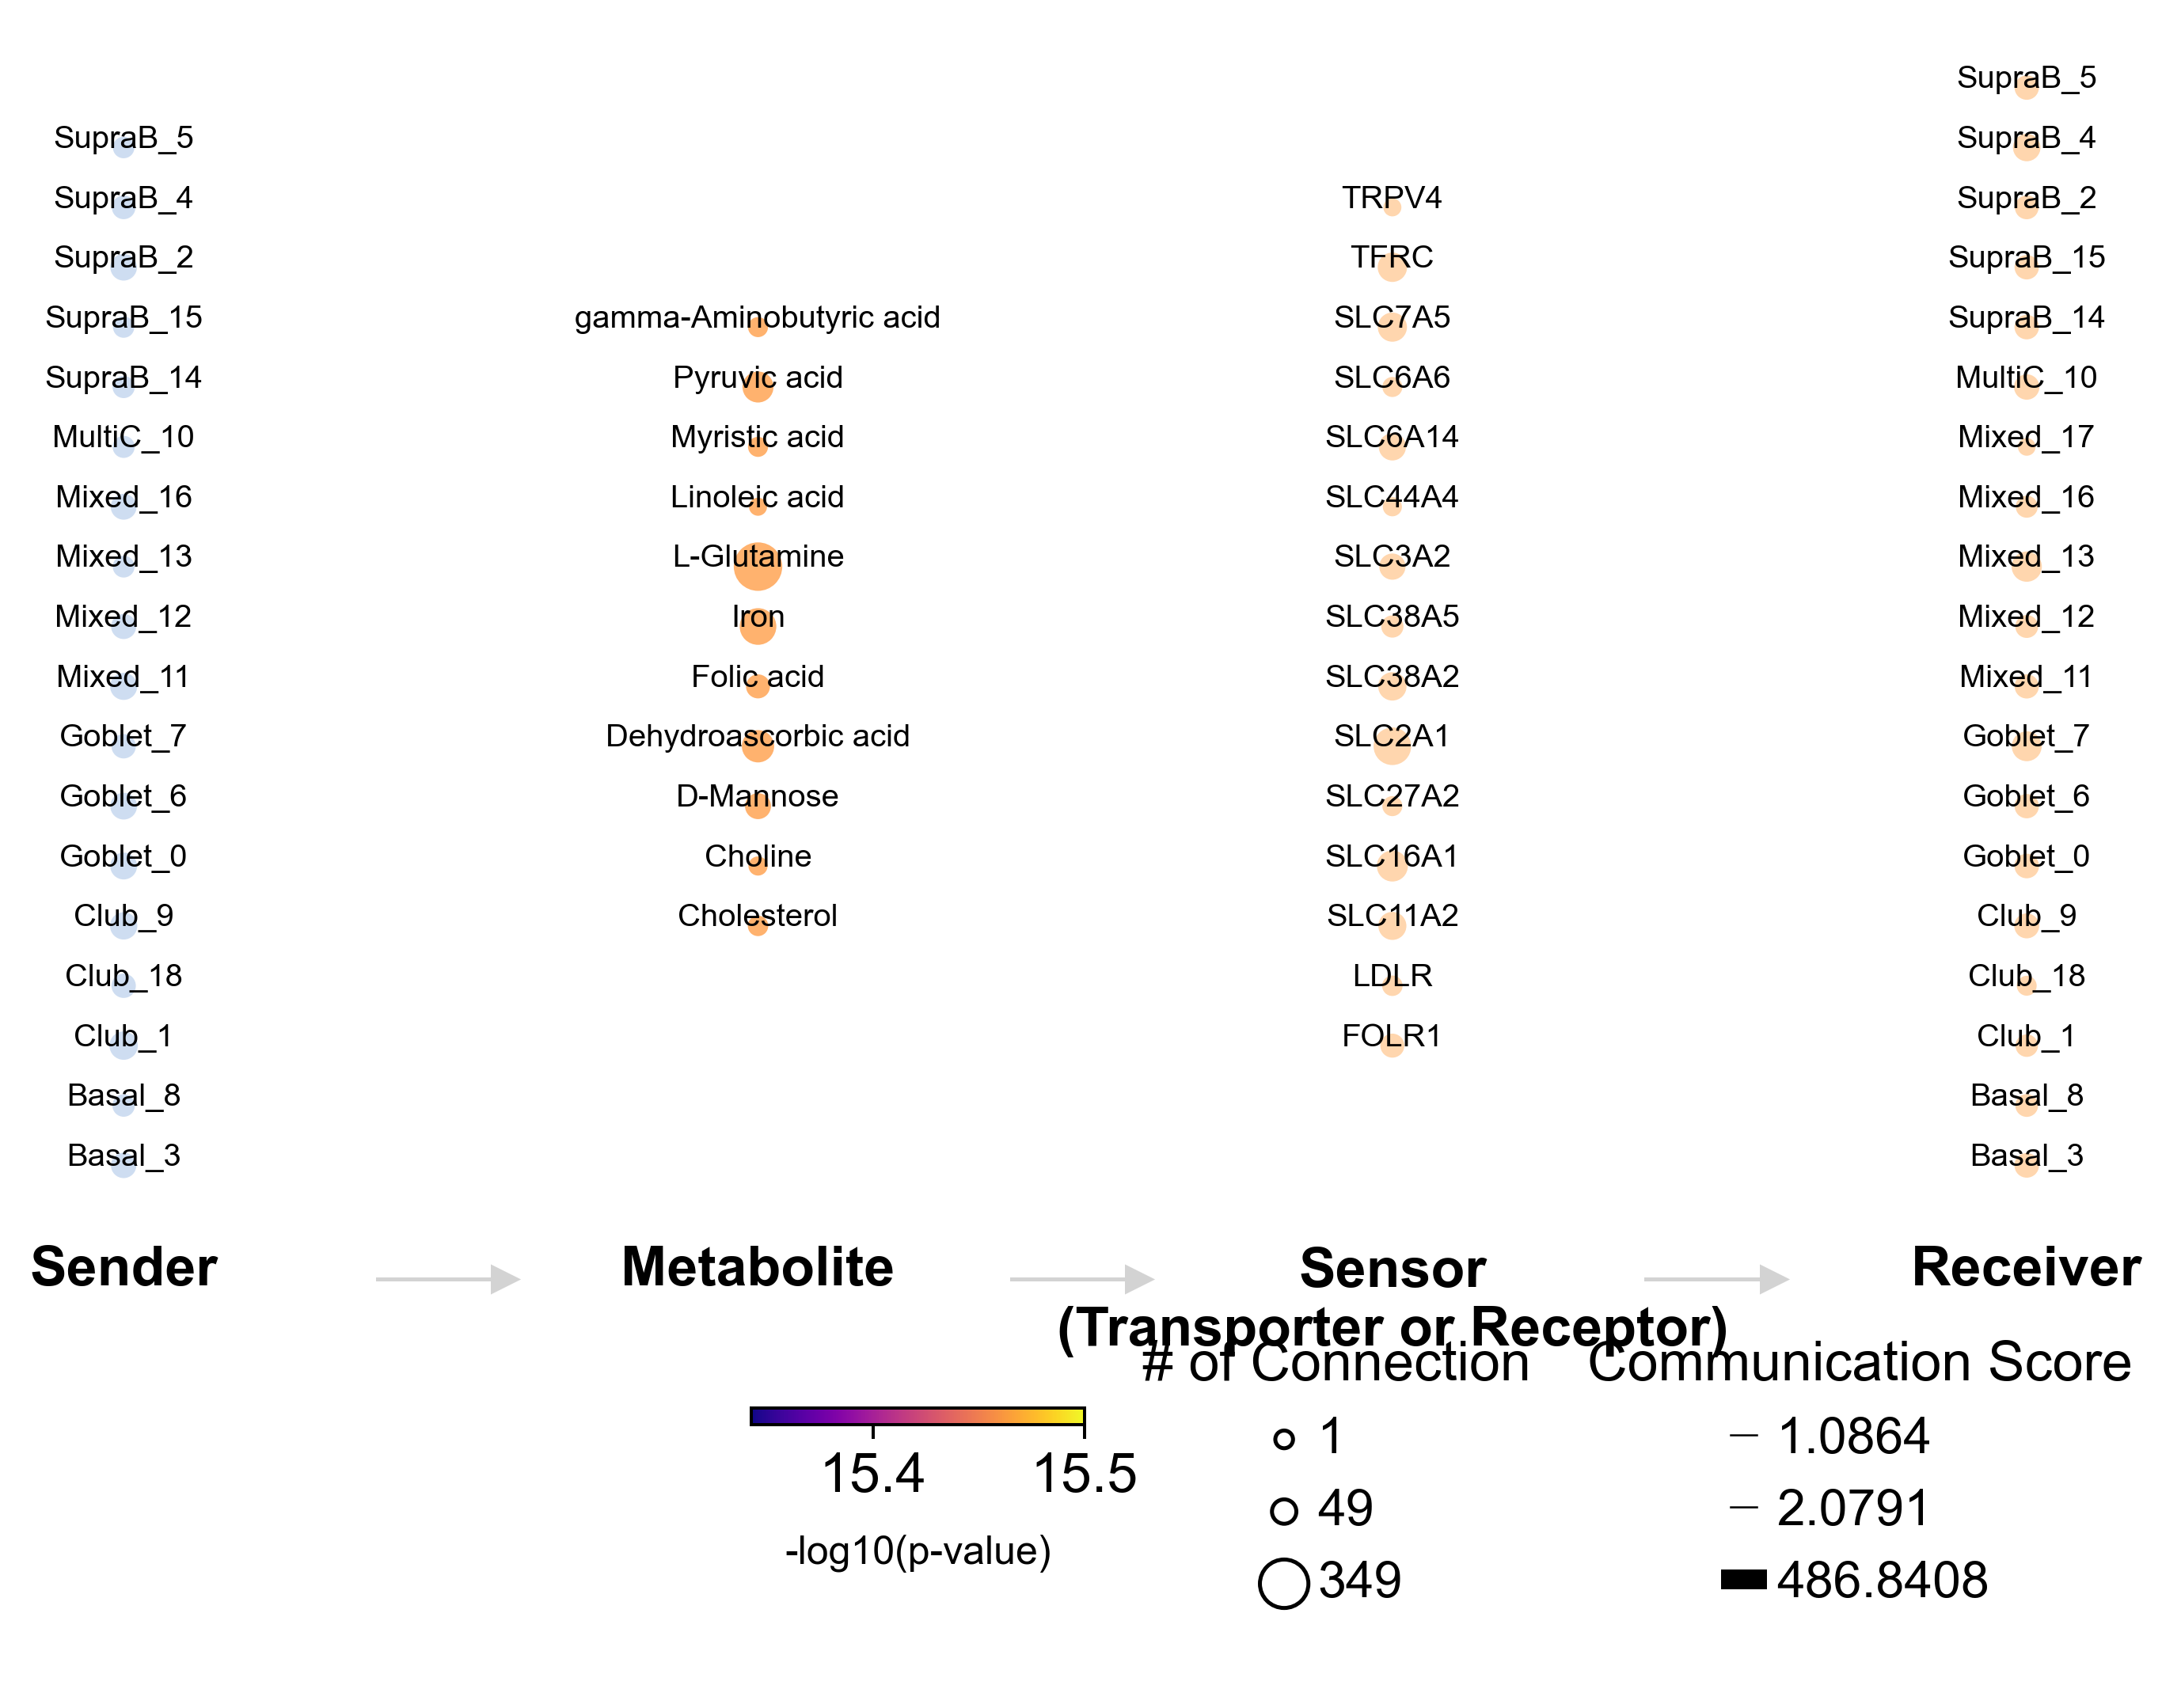

In [16]:
mebo_obj.FlowPlot(
                pval_method = 'permutation_test_fdr',
                pval_cutoff = 0.05,
                sender_focus = [],
                metabolite_focus = [],
                sensor_focus = [],
                receiver_focus = ['Goblet_12', 'Goblet_8', 'Basal_16'],
                remove_unrelevant = False,
                and_or = 'and',
                node_label_size = 8,
                node_alpha = 0.6,
                figsize = 'auto',
                node_cmap = 'tab20',
                line_cmap = 'plasma',
                line_vmin = None,
                line_vmax = 15.5,
                node_size_norm = (20, 150),
                linewidth_norm = (0.5, 5),
                save = None,
                show_plot = True,
                comm_score_col = 'Commu_Score',
                comm_score_cutoff = 0,
                text_outline = False,
                return_fig = False
            )

[April 27, 2023 11:04:05]: plot flow plot to show the communications from Sender -> Metabolite -> Sensor -> Receiver


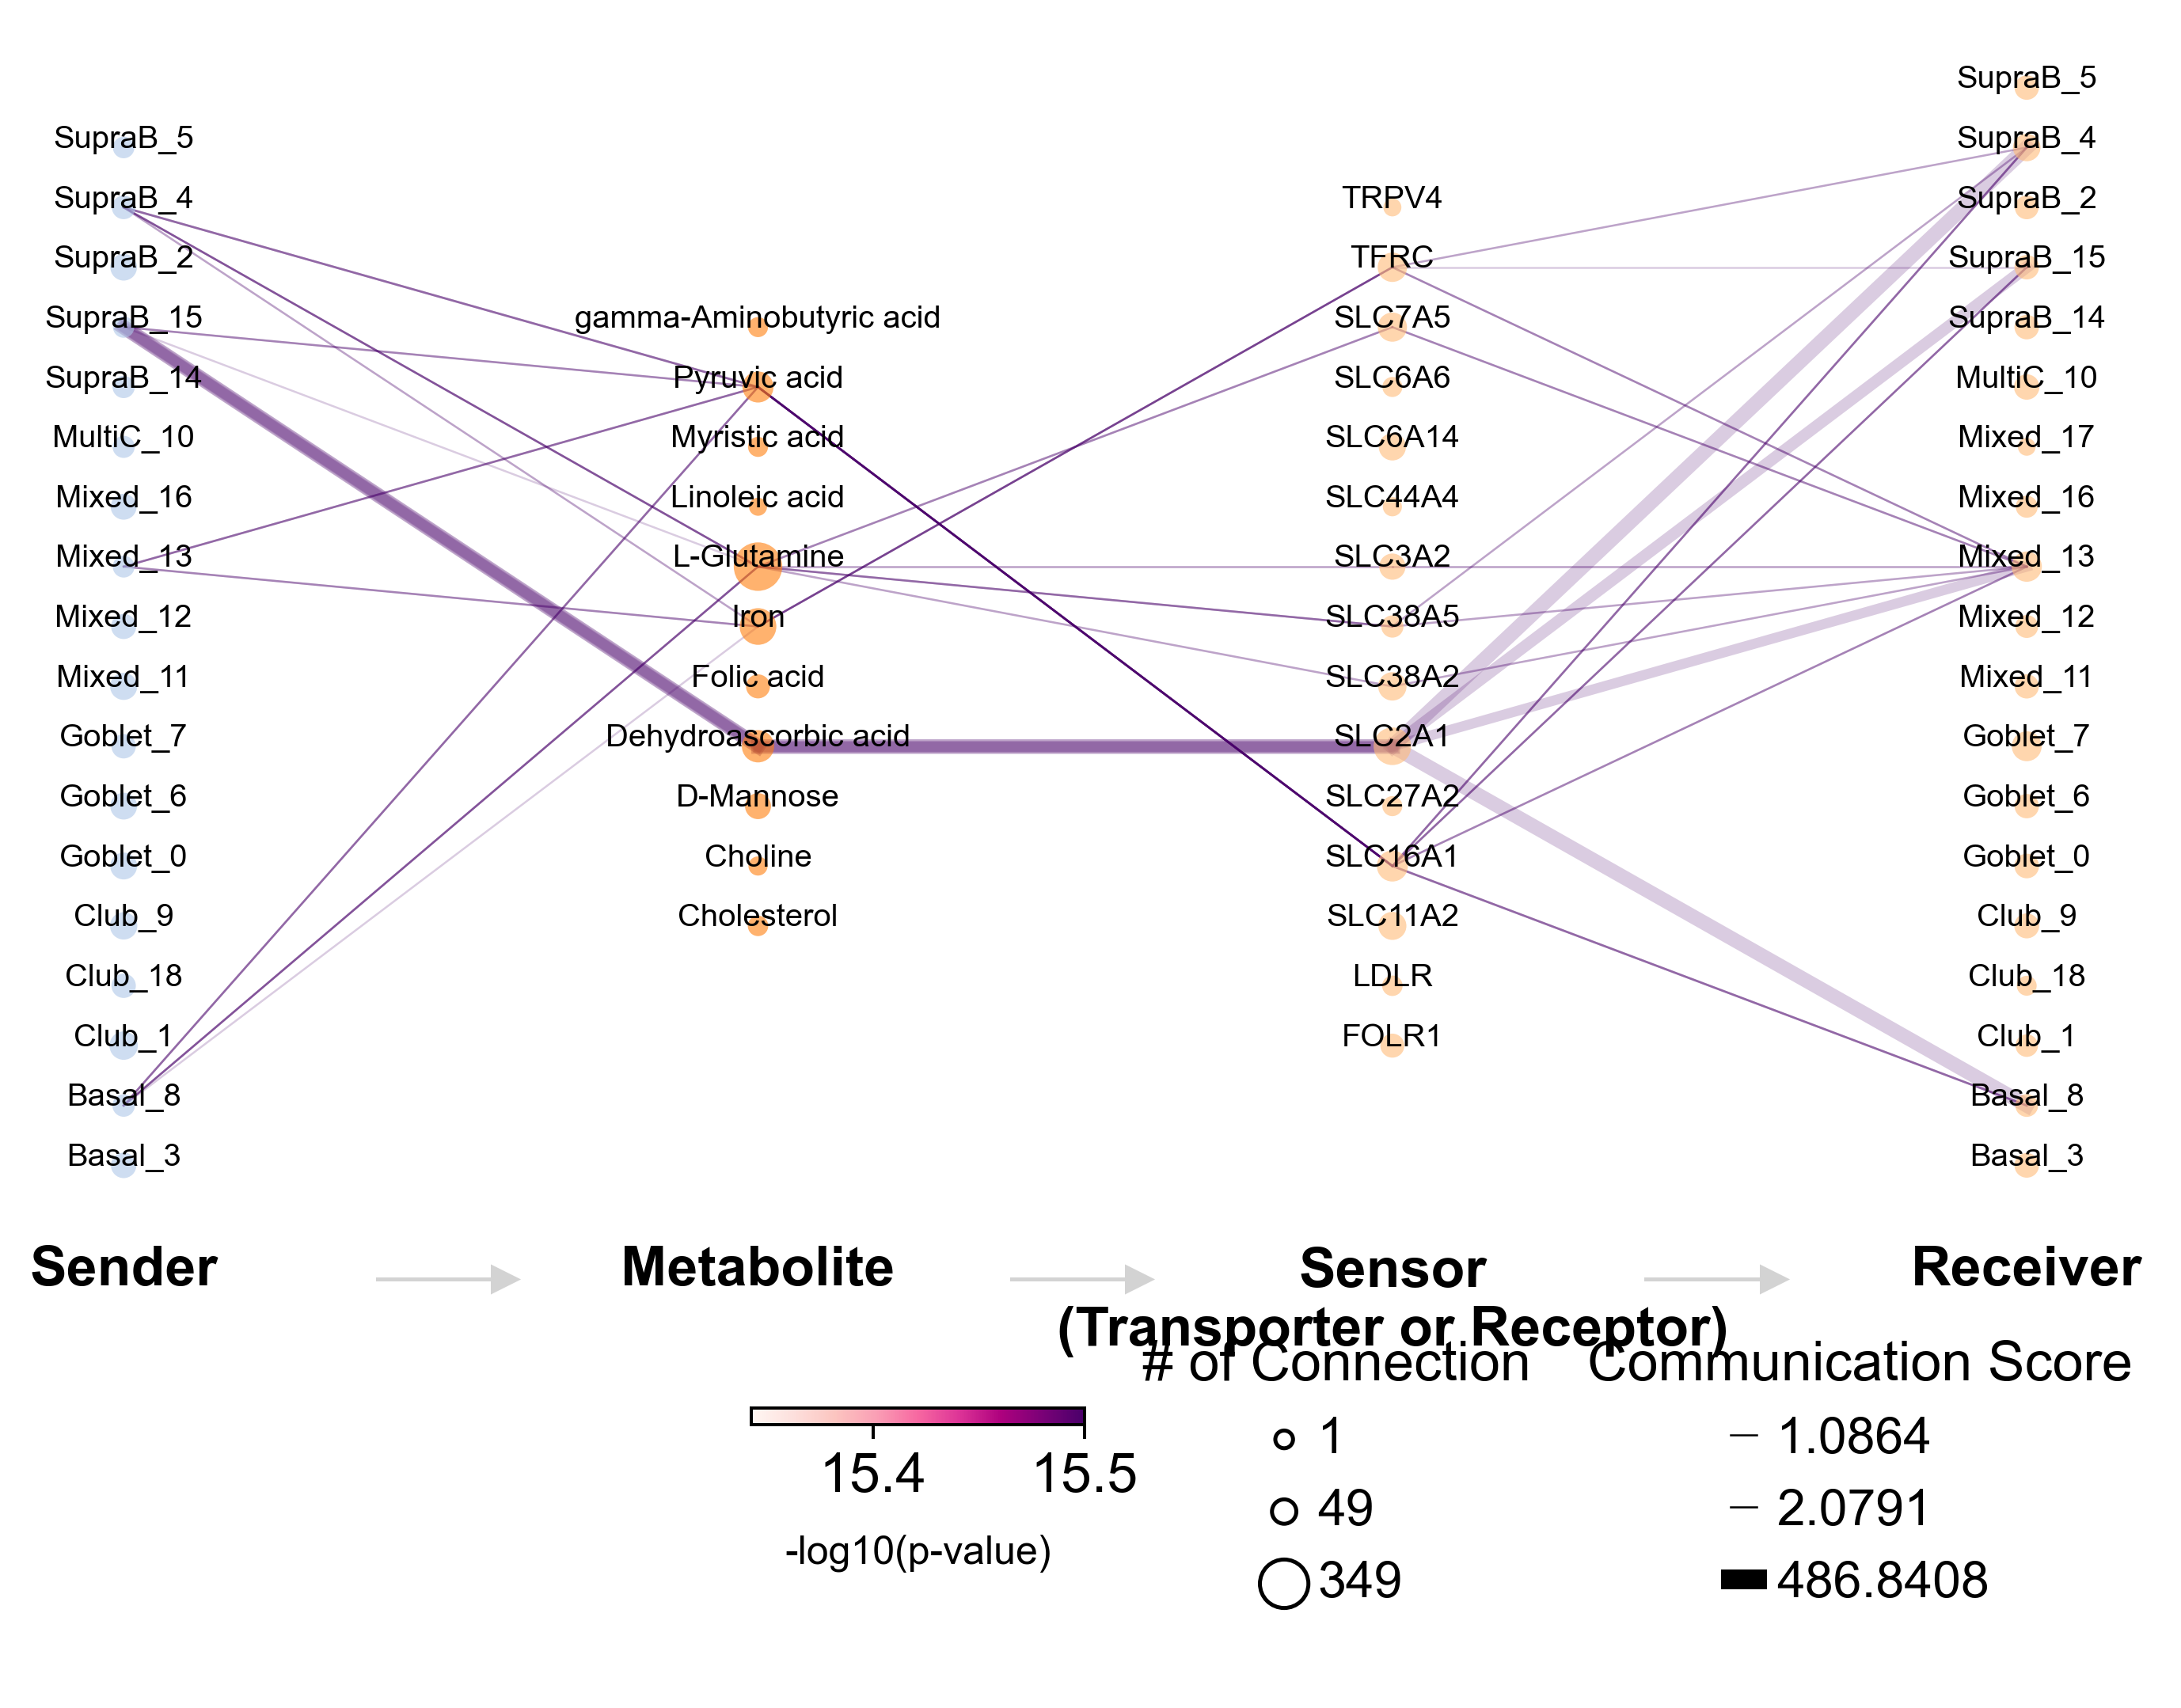

In [17]:
mebo_obj.FlowPlot(
                pval_method = 'permutation_test_fdr',
                pval_cutoff = 0.05,
                sender_focus = ['Mixed_13', 'SupraB_15', 'SupraB_4', 'Basal_8'],
                metabolite_focus = [],
                sensor_focus = [],
                receiver_focus = ['Mixed_13', 'SupraB_15', 'SupraB_4', 'Basal_8'],
                remove_unrelevant = False,
                and_or = 'and',
                node_label_size = 8,
                node_alpha = 0.6,
                figsize = 'auto',
                node_cmap = 'tab20',
                line_cmap = 'RdPu',
                line_vmin = None,
                line_vmax = 15.5,
                node_size_norm = (20, 150),
                linewidth_norm = (0.5, 5),
                save = None,
                show_plot = True,
                comm_score_col = 'Commu_Score',
                comm_score_cutoff = 0,
                text_outline = False,
                return_fig = False
            )

- Visualization of the metabolite level or sensor expression in cell groups

[April 27, 2023 11:04:06]: Warnings: no sensors to plot
[April 27, 2023 11:04:06]: Find metabolites ['Choline', 'D-Mannose', 'Cholesterol', 'Folic acid', 'Dehydroascorbic acid'] to plot violin


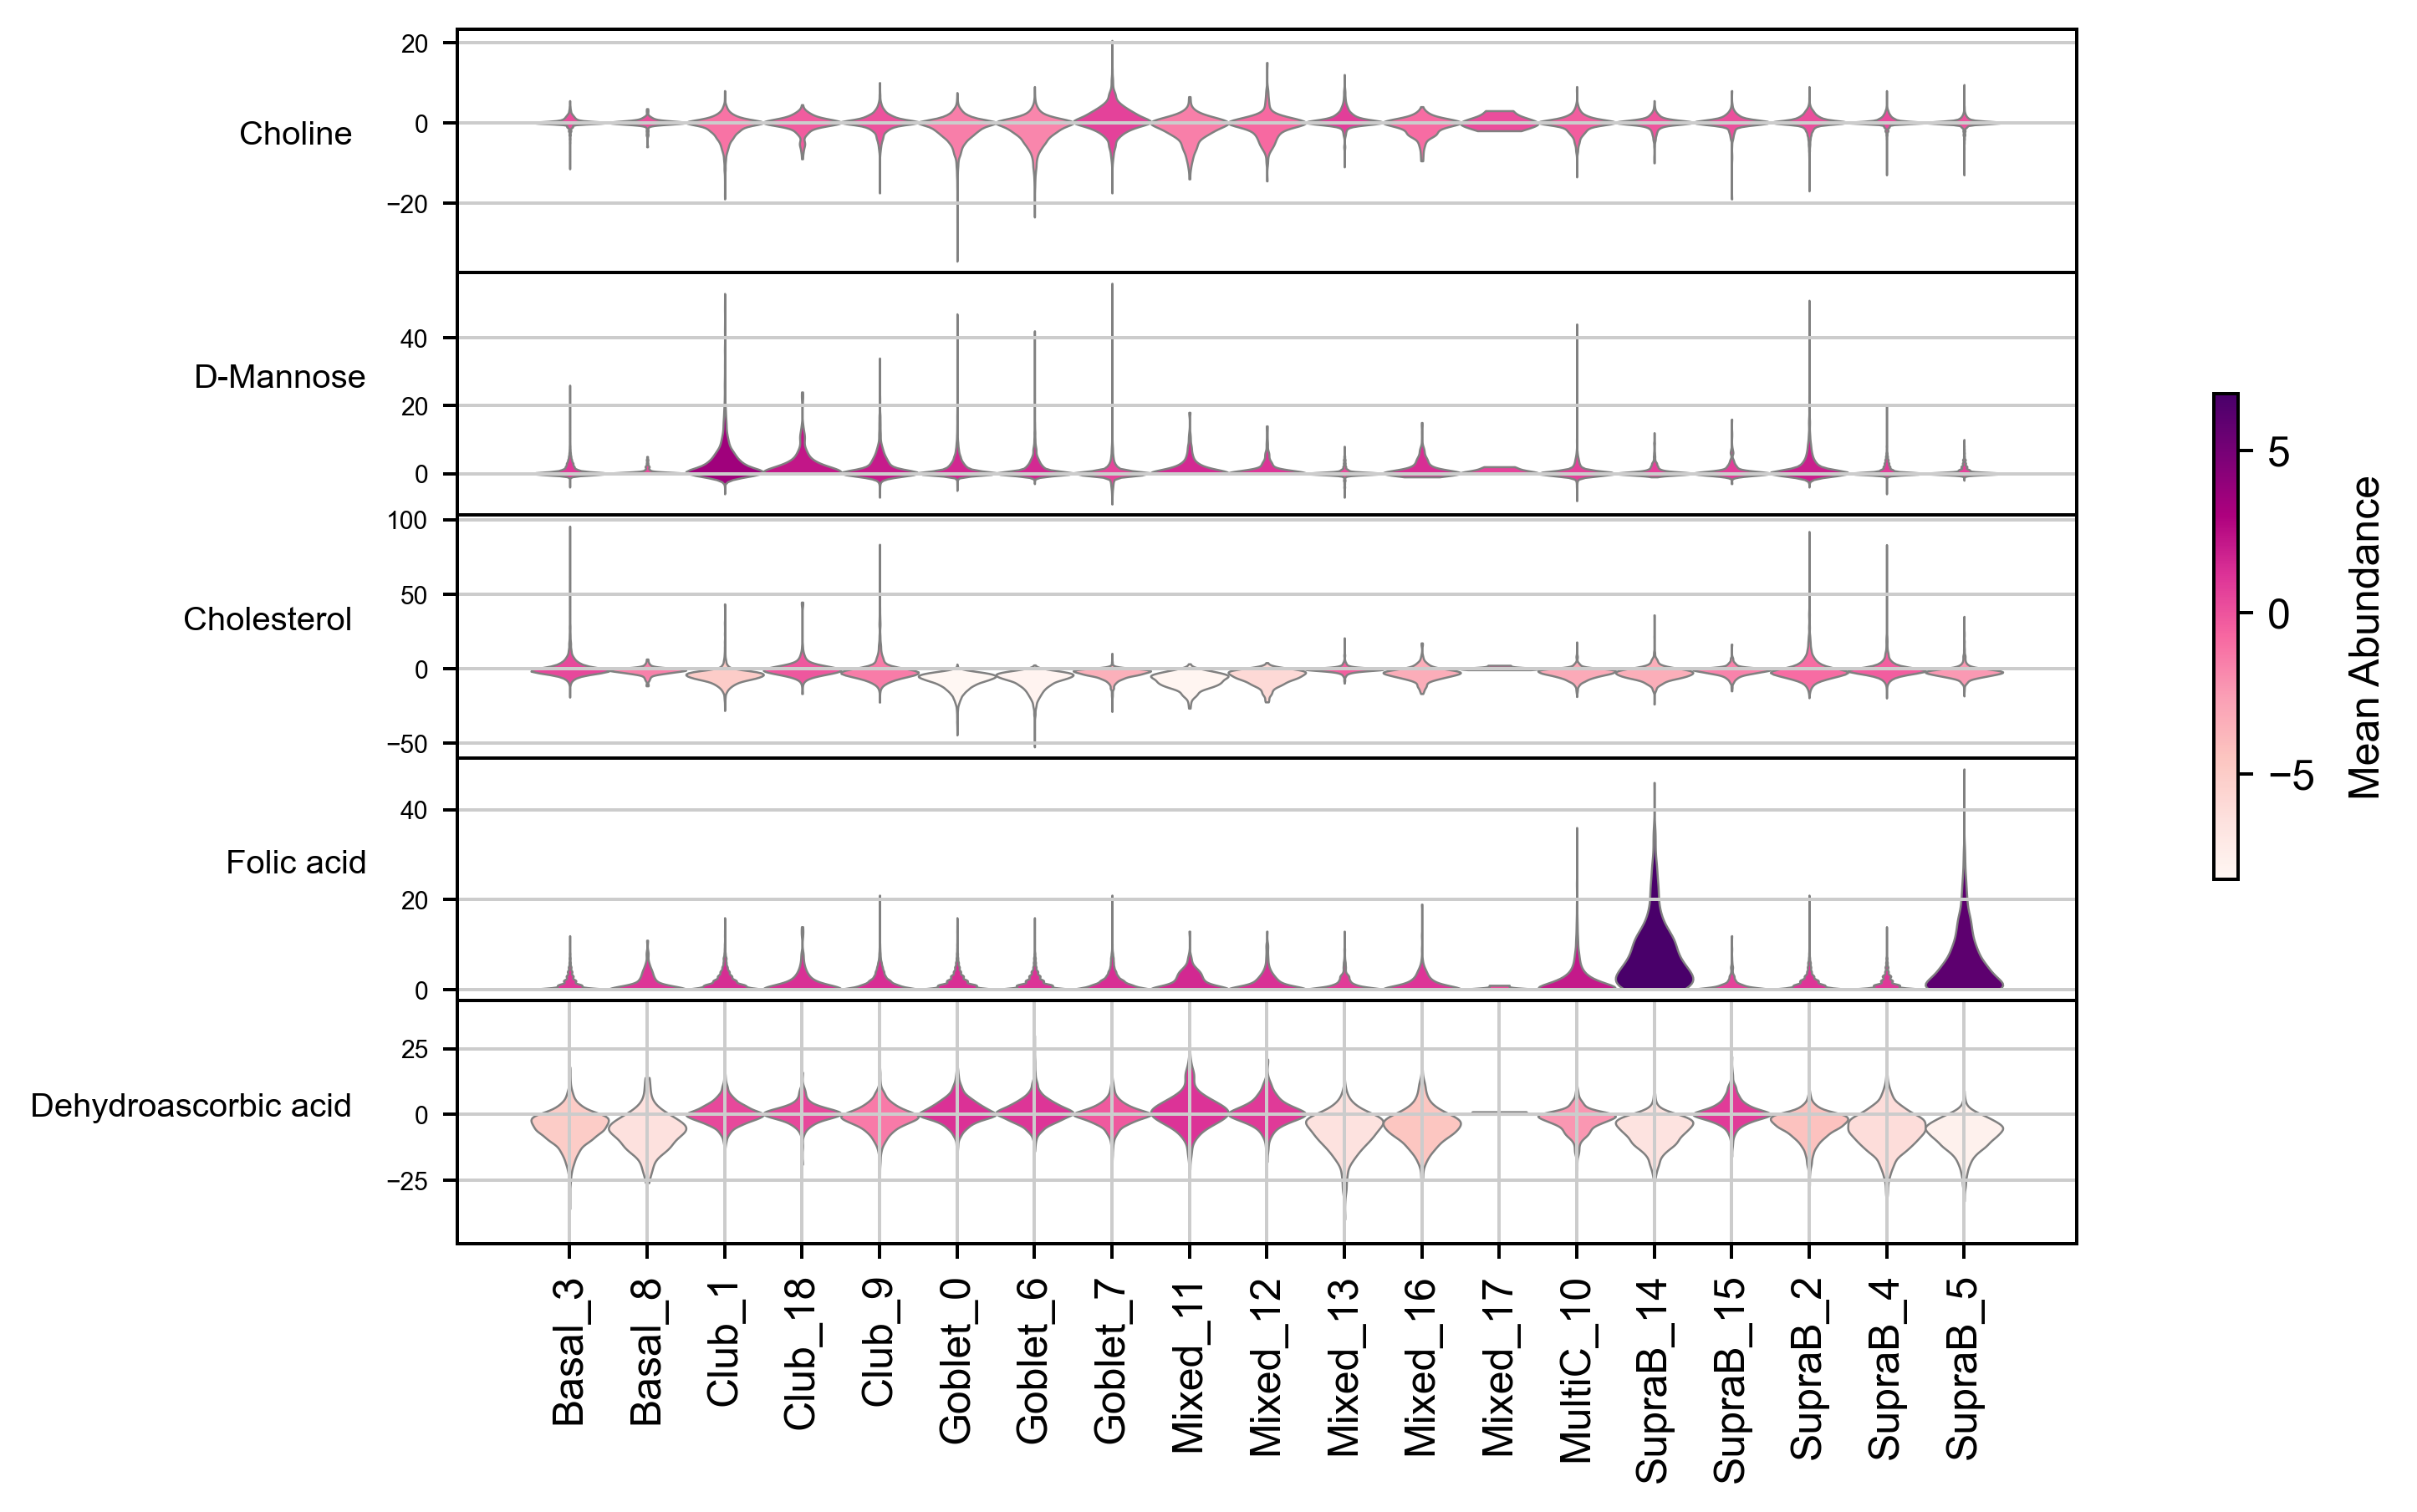

In [18]:
commu_df = mebo_obj.commu_res.copy()
good_met = commu_df[(commu_df['permutation_test_fdr']<=0.05)]['Metabolite_Name'].sort_values().unique()

mebo_obj.violin_plot(
                    sensor_or_met = good_met[:5], ## only top 5 as example
                    cell_focus = [],
                    cmap = 'RdPu',
                    vmin = None,
                    vmax = None,
                    figsize = 'auto',
                    cbar_title = '',
                    save = None,
                    show_plot = True
                    )

[April 27, 2023 11:04:08]: Find genes Index(['FOLR1', 'LDLR', 'SLC11A2', 'SLC16A1', 'SLC27A2', 'SLC2A1', 'SLC38A2',
       'SLC38A5', 'SLC3A2', 'SLC44A4'],
      dtype='object') to plot violin


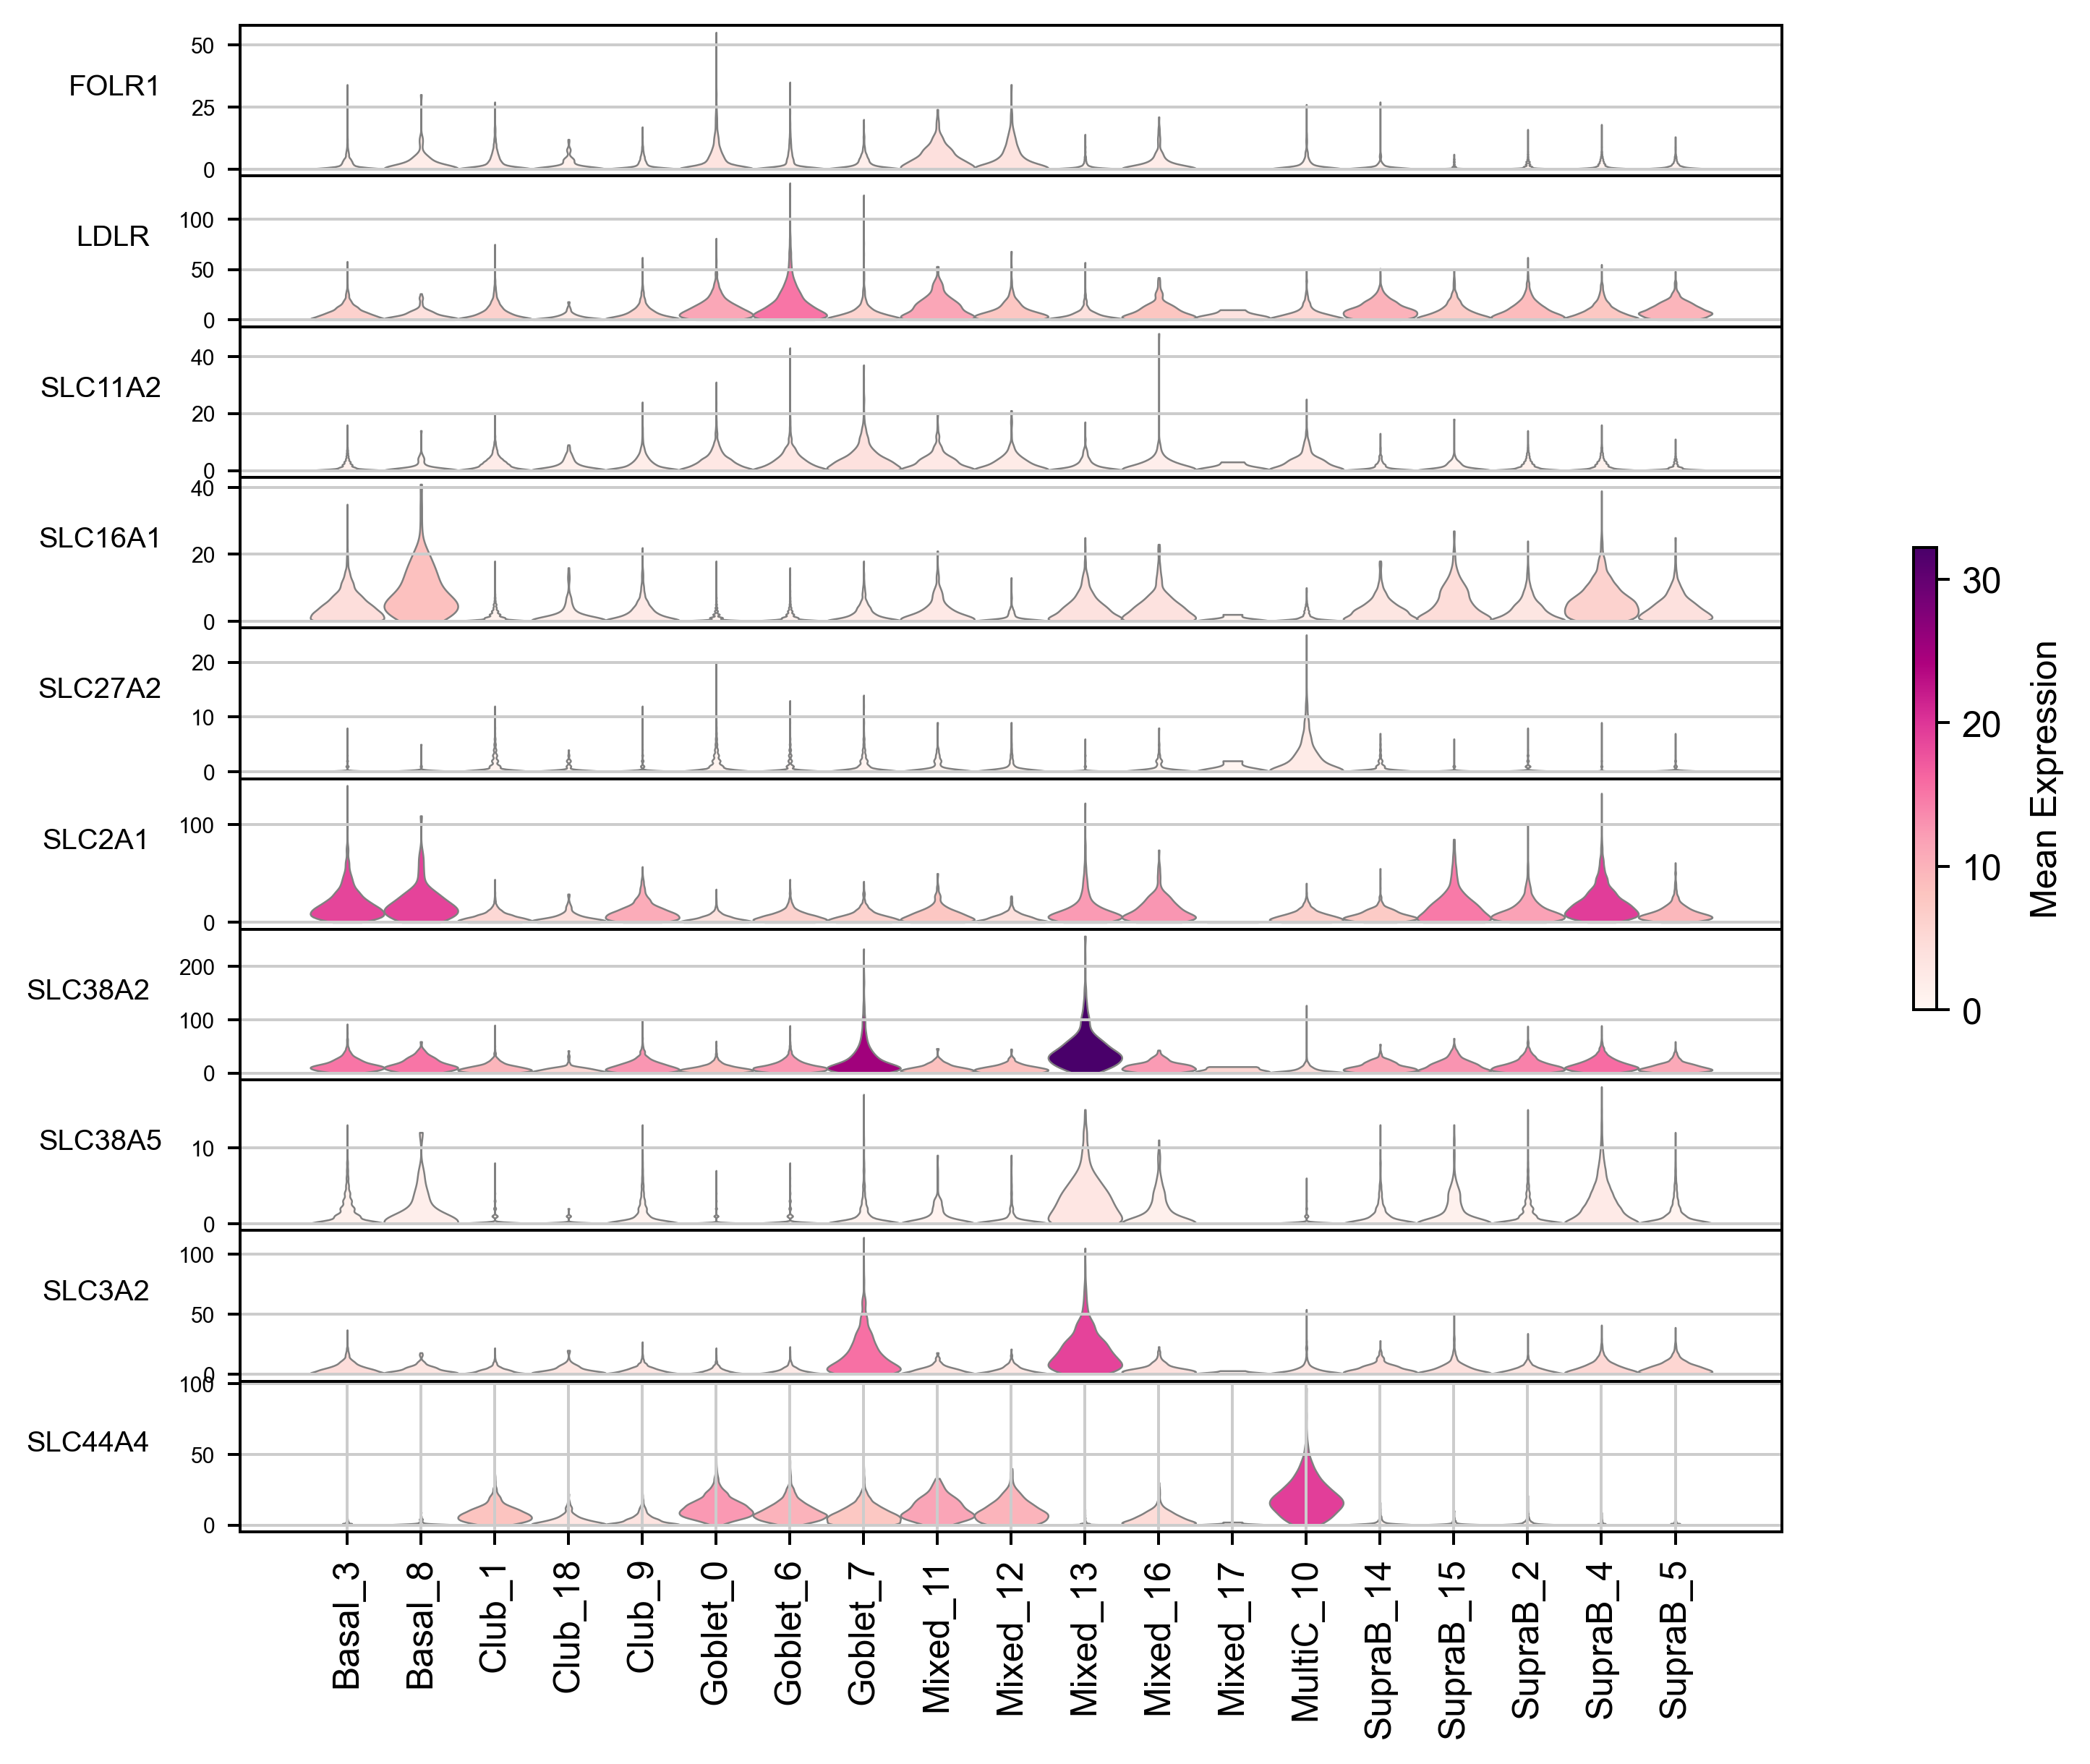

[April 27, 2023 11:04:10]: Warnings: no metabolites to plot


In [19]:
good_sensor = commu_df[(commu_df['permutation_test_fdr']<=0.05)]['Sensor'].sort_values().unique()

mebo_obj.violin_plot(
                    sensor_or_met = good_sensor[:10],## only top 5 as example
                    cell_focus = [],
                    cmap = 'RdPu',
                    vmin = None,
                    vmax = None,
                    figsize = 'auto',
                    cbar_title = '',
                    save = None,
                    show_plot = True
                    )